## Show model

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model(
            'cls_mbv2_v8.h5', compile=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [1]:
## convert keras h5 model to tensorflow serving model
model.save('classifier_model/')

## Import

In [2]:
import requests
from PIL import Image
import numpy as np
import json
import datetime

image_type = [
            '決算報告書表紙',
            '貸借対照表',
            '損益計算書',
            '製造原価明細表',
            '販売費及び一般管理費',
            '利益処分書',
            '株主資本等変動計算書',
            '個別注記表',
            'その他',
            '２ページ'
        ]

image_direction = {
    0: '上',
    1: '左',
    2: '下',
    3: '右',
}

uwsgi_url = 'http://localhost:9002/prediction/classifier'

tfs_url = 'http://localhost:8501/v1/models/classifier:predict'

## preprocessing functions

In [5]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def preprocess_func(im):
    im.thumbnail((512,512), Image.ANTIALIAS)
    sqim = expand2square(im, (255, 255, 255))
    npim = np.array(sqim)
    npim = npim[:, :, 0:3]
    npim = npim / 255.0
    return npim

def show_timestamp(prefix = 'timestamp'):
    now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))) # 日本時刻
    print(f'{prefix} : {now.strftime("%Y%m%d %H:%M:%S")}')

## uWSGI server request

In [6]:
### Test server
response = requests.get('http://localhost:9002/index')
response.text

"<span style='color:red'>I am uwsgi app</span>"

In [9]:
### build request body
im = Image.open('sample3.png').convert('RGB')
image_array = preprocess_func(im)
print(image_array.shape)
images = []
images.append(image_array.tolist())

### send request
headers = {"content-type": "application/json"}
request_body = {"instances": images}
# show_timestamp('start')
response = requests.post(uwsgi_url, data=json.dumps(request_body), headers = headers)
# show_timestamp('end')

### post process show reuslts
json_dict = json.loads(response.text)
f'種類 : {image_type[json_dict[0]["type_idx"]]}; 方向 : {image_direction[json_dict[0]["rot_idx"]]}'

(512, 512, 3)


'種類 : 製造原価明細表; 方向 : 下'

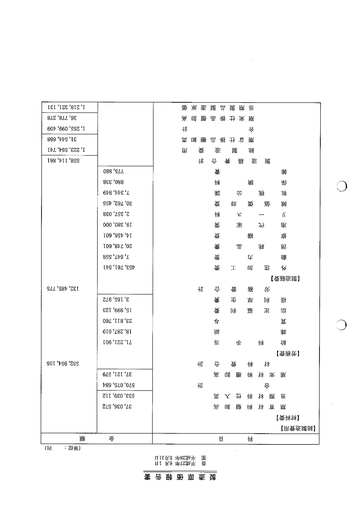

In [10]:
im

## Tensorflow serving request

In [15]:
### test TF serving is alive
response = requests.get('http://localhost:8501/v1/models/classifier/metadata')
print(json.loads(response.text))

{'model_spec': {'name': 'classifier', 'signature_name': '', 'version': '2'}, 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'input_1': {'dtype': 'DT_FLOAT', 'tensor_shape': {'dim': [{'size': '-1', 'name': ''}, {'size': '512', 'name': ''}, {'size': '512', 'name': ''}, {'size': '3', 'name': ''}], 'unknown_rank': False}, 'name': 'serving_default_input_1:0'}}, 'outputs': {'doc_type': {'dtype': 'DT_FLOAT', 'tensor_shape': {'dim': [{'size': '-1', 'name': ''}, {'size': '10', 'name': ''}], 'unknown_rank': False}, 'name': 'StatefulPartitionedCall:0'}, 'rot_int': {'dtype': 'DT_FLOAT', 'tensor_shape': {'dim': [{'size': '-1', 'name': ''}, {'size': '4', 'name': ''}], 'unknown_rank': False}, 'name': 'StatefulPartitionedCall:1'}}, 'method_name': 'tensorflow/serving/predict'}, '__saved_model_init_op': {'inputs': {}, 'outputs': {'__saved_model_init_op': {'dtype': 'DT_INVALID', 'tensor_shape': {'dim': [], 'unknown_rank': True}, 'name': 'NoOp'}}, 'method_name': ''}}}}}


In [12]:
### build request body
im = Image.open('sample3.png').convert('RGB')
image_array = preprocess_func(im)
print(image_array.shape)
images = []
images.append(image_array.tolist())

### send request
headers = {"content-type": "application/json"}
request_body = {"instances": images, 'signature_name': 'serving_default',}
# show_timestamp('start')
response = requests.post(tfs_url, data=json.dumps(request_body), headers = headers)
# show_timestamp('start')
result = json.loads(response.text)
result

(512, 512, 3)


{'predictions': [{'rot_int': [3.62079646e-07,
    7.54815176e-07,
    0.999994516,
    4.42983946e-06],
   'doc_type': [6.96528275e-08,
    6.4372432e-07,
    1.17944285e-06,
    0.999995708,
    1.19812273e-06,
    1.09815922e-07,
    4.32666411e-07,
    1.61547533e-07,
    3.17374628e-07,
    2.23343122e-07]}]}

In [13]:
## convert to onehot
predictions = []
for rslt in result['predictions']:
    doc_type = rslt['doc_type']
    doc_type_idx = doc_type.index(max(doc_type))

    rotation = rslt['rot_int']
    rotation_idx = rotation.index(max(rotation))

    predictions.append({'type_idx' : doc_type_idx, 'rot_idx' : rotation_idx})

f'種類 : {image_type[predictions[0]["type_idx"]]}; 方向 : {image_direction[predictions[0]["rot_idx"]]}'

'種類 : 製造原価明細表; 方向 : 下'

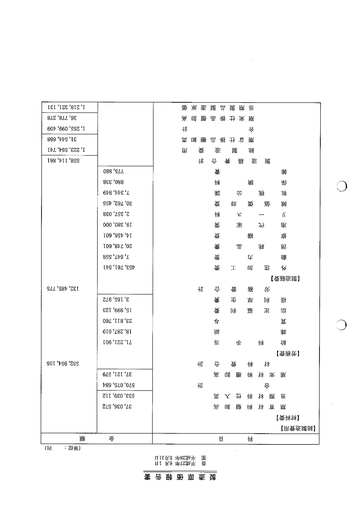

In [14]:
im